
# Training a Custom Model Using Sorting Analyzer

This tutorial demonstrates how to train a custom machine learning classifier for automated 
spike sorting curation using UnitRefine. While pre-trained models work well for many datasets, 
custom models can achieve better performance on specific experimental conditions or recording setups.

## Overview:
1. Load recordings 
2. Compute quality and template metrics
3. Train and evaluate multiple classifiers
4. Analyze model performance and feature importance

Note: For real applications, replace the simulated data with your own recordings and manual curation labels.



### Import packages 

In [3]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spikeinterface as si
import spikeinterface.widgets as sw

# Print versions for reproducibility
print(f"SpikeInterface version: {si.__version__}")


from pathlib import Path
# Import UnitRefine - adjust path if needed
try:
    from UnitRefine.scripts.train_manual_curation import train_model
    print("✓ UnitRefine imported successfully")
except ImportError:
    # If UnitRefine is not installed, add the local path
    import sys
    # Get current working directory and navigate to UnitRefine root
    current_path = Path.cwd()
    # Navigate to the directory containing the UnitRefine folder
    unitrefine_root = current_path.parent.parent.parent  # Go to c:\Users\jain\Documents\GitHub\UnitRefine
    sys.path.append(str(unitrefine_root))
    from UnitRefine.scripts.train_manual_curation import train_model
    print("✓ UnitRefine imported from local path")

## Alternative: Import from SpikeInterface package (if available)
# from spikeinterface.curation import train_model

# Configure for performance (adjust based on your system)
si.set_global_job_kwargs(n_jobs=4)
print("Tutorial setup complete!")

SpikeInterface version: 0.102.3
✓ UnitRefine imported successfully
Tutorial setup complete!


## Step 1: Get Spike sorted outputs

For this tutorial, 

For this tutorial, we will use simulated data to create - **recording** and - **sorting objects**. We'll create two instances since we commend to use at least two recordings to create a custom machine learning classifier.

We combine both sortings using `si.aggregate_units()` to create a dataset.

**For real applications:** Replace this simulated data with your actual experimental recordings. You should:
1. [Load your own recordings](https://spikeinterface.readthedocs.io/en/latest/modules/extractors.html)
2. [Perform spike sorting](https://spikeinterface.readthedocs.io/en/latest/modules/sorters.html) 


In [4]:
print("Generating simulated data...")
# Generate realistic units (coupled to recording)
recording, sorting_1 = si.generate_ground_truth_recording(
    num_channels=4, 
    seed=1, 
    num_units=10,
    durations=[300.0],  # 5 minutes of data
    sampling_frequency=30000
)

# Generate noise-like units (uncoupled from recording)
_, sorting_2 = si.generate_ground_truth_recording(
    num_channels=4, 
    seed=2, 
    num_units=10,
    durations=[300.0],
    sampling_frequency=30000
)

# Display unit counts for each sorting
print(f"Sorting 1  (units): {len(sorting_1.get_unit_ids())} units")
print(f"Sorting 2  (units): {len(sorting_2.get_unit_ids())} units")

# Combine both sortings
both_sortings = si.aggregate_units([sorting_1, sorting_2])

print(f"Combined sorting: {len(both_sortings.get_unit_ids())} total units")
print(f"Recording duration: {recording.get_total_duration():.1f} seconds")
print(f"Sampling frequency: {recording.get_sampling_frequency()} Hz")

# Show unit ID mapping
print(f"\nUnit ID mapping:")
print(f"  - Units 0-9: from sorting_1")
print(f"  - Units 10-19: from sorting_2")

Generating simulated data...
Sorting 1  (units): 10 units
Sorting 2  (units): 10 units
Combined sorting: 20 total units
Recording duration: 300.0 seconds
Sampling frequency: 30000.0 Hz

Unit ID mapping:
  - Units 0-9: from sorting_1
  - Units 10-19: from sorting_2


## Step 2: Compute Quality and Template Metrics

UnitRefine models are trained on quantitative features that describe unit quality. These features come from two main sources:

- **[Quality metrics](https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html)**: Measures like ISI violations, firing rate, presence ratio, signal-to-noise ratio
- **[Template metrics](https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html#template-metrics)**: Waveform characteristics like peak-to-trough ratio, spatial spread, velocity

These metrics are computed using a `SortingAnalyzer` object, which efficiently handles the analysis pipeline. Learn more about [SortingAnalyzer here](https://spikeinterface.readthedocs.io/en/stable/tutorials/core/plot_4_sorting_analyzer.html).

In [5]:
print("Creating sorting analyzer...")
analyzer = si.create_sorting_analyzer(sorting=both_sortings, recording=recording)

print("Computing extensions (this may take a few minutes)...")
# Compute all necessary extensions for quality and template metrics
extensions = [
    'noise_levels',           # Background noise estimation
    'random_spikes',          # Random spike sampling  
    'waveforms',             # Spike waveform extraction
    'templates',             # Average waveform templates
    'spike_locations',       # Spatial spike locations
    'spike_amplitudes',      # Spike amplitude measurements
    'correlograms',          # Auto/cross-correlograms
    'principal_components',  # PC analysis
    'quality_metrics',       # Quality assessment metrics
    'template_metrics'       # Template shape metrics
]

analyzer.compute(extensions)

# Display summary of computed metrics
quality_metrics = analyzer.get_extension('quality_metrics').get_data()
template_metrics = analyzer.get_extension('template_metrics').get_data()

print(f"\n✓ Analysis complete!")
print(f"  - {len(quality_metrics.columns)} quality metrics computed")
print(f"  - {len(template_metrics.columns)} template metrics computed")
print(f"  - Total: {len(quality_metrics.columns) + len(template_metrics.columns)} features available for training")

Creating sorting analyzer...


estimate_sparsity (workers: 4 processes):   0%|          | 0/300 [00:00<?, ?it/s]

Computing extensions (this may take a few minutes)...


noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (workers: 4 processes):   0%|          | 0/300 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/20 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/20 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (workers: 4 processes):   0%|          | 0/300 [00:00<?, ?it/s]

noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/20 [00:00<?, ?it/s]


✓ Analysis complete!
  - 27 quality metrics computed
  - 7 template metrics computed
  - Total: 34 features available for training


## Step 3: Create Training Labels

Now we need to create labels for our training data. In real applications, each recording would contain both good and bad units mixed together. To simulate this more realistic scenario, we'll randomly assign labels to units from both recordings.

**Note:** In real applications, these labels would come from manual curation using tools like UnitRefine GUI or Phy.

In [6]:
# Create realistic mixed labels for both recordings
# In real applications, each recording would have both good and bad units

import random

unit_ids = both_sortings.get_unit_ids()
total_units = len(unit_ids)

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# Create mixed labels - approximately 60% good, 40% bad (realistic ratio)
n_good = int(total_units * 0.6)
n_bad = total_units - n_good

labels = ['good'] * n_good + ['bad'] * n_bad
# Shuffle to create random distribution across both recordings
random.shuffle(labels)

print(f"Created realistic mixed labels for {len(labels)} units:")
print(f"  - Good units: {labels.count('good')} ({labels.count('good')/len(labels)*100:.1f}%)")
print(f"  - Bad units: {labels.count('bad')} ({labels.count('bad')/len(labels)*100:.1f}%)")

# Show label distribution for each recording
sorting_1_labels = labels[:10]  # First 10 units from sorting_1
sorting_2_labels = labels[10:]  # Last 10 units from sorting_2

print(f"\nLabel distribution by recording:")
print(f"  - Recording 1 (units 0-9): {sorting_1_labels.count('good')} good, {sorting_1_labels.count('bad')} bad")
print(f"  - Recording 2 (units 10-19): {sorting_2_labels.count('good')} good, {sorting_2_labels.count('bad')} bad")
print(f"  - Complete labels: {labels}")

Created realistic mixed labels for 20 units:
  - Good units: 12 (60.0%)
  - Bad units: 8 (40.0%)

Label distribution by recording:
  - Recording 1 (units 0-9): 4 good, 6 bad
  - Recording 2 (units 10-19): 8 good, 2 bad
  - Complete labels: ['bad', 'good', 'bad', 'good', 'good', 'bad', 'bad', 'bad', 'good', 'bad', 'bad', 'good', 'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good']


## Step 4: Train the Classifier

Now we train a machine learning classifier to distinguish between good and bad units based on the computed metrics. UnitRefine uses an automated pipeline that tests different model configurations to find the best performing combination.

### Training Pipeline:

**🔄 Model Selection**: Tests multiple algorithms (Random Forest, Gradient Boosting, Logistic Regression, etc.)

**🔧 Data Preprocessing**: 
- **Imputation**: Handles missing values using strategies like median, mean, or mode
- **Feature scaling**: Normalizes metrics using StandardScaler, RobustScaler, etc.

### Tutorial Settings:
For demonstration purposes, we'll use simplified settings to reduce computation time. In production, you'd test more combinations for better performance.

In [7]:
print("🚀 Starting model training...")
print("This will test different combinations of classifiers, scaling, and imputation strategies.\n")

# Define output folder for the trained model
folder = "my_custom_model"

# For realtime use, consider using multiple analyzers from different recordings
# This improves model generalization across different experimental conditions
trainer = train_model(
    mode="analyzers",                    # Use SortingAnalyzer objects as input
    labels=[labels],                     # List of label arrays (one per analyzer)
    analyzers=[analyzer],                # List of SortingAnalyzer objects
    folder=folder,                       # Output directory for model files
    
    # Feature selection (None = use all computed metrics)
    metric_names=None,
    
    # Data preprocessing options
    imputation_strategies=["median"],    # How to handle missing values
    scaling_techniques=["standard_scaler"], # Feature normalization methods
    
    # Machine learning algorithms to test
    # Available: ["RandomForestClassifier","GradientBoostingClassifier", "AdaBoostClassifier", 
    #            "LogisticRegression", "MLPClassifier"]
    classifiers=["RandomForestClassifier", "GradientBoostingClassifier"],

    # File management
    overwrite=True                      # Overwrite existing model folder
)

# Access the best performing model (the train_model function handles the completion messages)
best_model = trainer.best_pipeline

🚀 Starting model training...
This will test different combinations of classifiers, scaling, and imputation strategies.



In [8]:
best_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', min_samples_leaf=2,
                                        min_samples_split=4, n_estimators=134,
                                        random_state=np.int64(562900505)))])

## Training Results and Model Files

The training process creates several important files in the output folder:

### 📁 Generated Files:

- **`best_model.skops`**: The trained classifier in skops format (secure alternative to pickle)
- **`model_info.json`**: Metadata including training parameters, feature names, and model configuration  
- **`model_accuracies.csv`**: Performance metrics (accuracy, precision, recall) for all tested combinations
- **`labels.csv`**: The training labels used
- **`training_data.csv`**: The feature matrix used for training

### 🔍 About skops Format:
[Skops](https://skops.readthedocs.io/en/stable/index.html) is a secure, Python-native alternative to pickle that's designed specifically for scikit-learn models. It prevents code execution vulnerabilities while maintaining compatibility.

Let's examine the model performance:

In [9]:
# Load and display model performance results
accuracies = pd.read_csv(Path(folder) / "model_accuracies.csv", index_col=0)

print("📊 Model Performance Summary:")
print("=" * 50)

# Display key performance metrics
best_accuracy = accuracies['balanced_accuracy'].max()
best_precision = accuracies['precision'].max()  
best_recall = accuracies['recall'].max()

print(f"🎯 Best Accuracy:  {best_accuracy:.3f}")
print(f"🎯 Best Precision: {best_precision:.3f}")
print(f"🎯 Best Recall:    {best_recall:.3f}")

print(f"\n📋 All tested configurations:")
print(accuracies.round(3))

# Show the best performing configuration details
best_idx = accuracies['balanced_accuracy'].idxmax()
best_config = accuracies.loc[best_idx]
print(f"\n🏆 Best Configuration:")
print(f"   Classifier: {best_config.get('classifier name', 'RandomForestClassifier')}")
print(f"   Imputation: {best_config.get('imputation_strategy', 'median')}")  
print(f"   Scaling: {best_config.get('scaling_strategy', 'standard_scaler')}")

# Show model files created
model_files = list(Path(folder).glob('*'))
print(f"\n📁 Files created ({len(model_files)} total):")
for file_path in sorted(model_files):
    size_kb = file_path.stat().st_size / 1024
    print(f"   {file_path.name}: {size_kb:.1f} KB")

📊 Model Performance Summary:
🎯 Best Accuracy:  0.250
🎯 Best Precision: 0.167
🎯 Best Recall:    0.250

📋 All tested configurations:
              classifier name imputation_strategy  scaling_strategy  \
0      RandomForestClassifier              median  StandardScaler()   
1  GradientBoostingClassifier              median  StandardScaler()   

   balanced_accuracy  precision  recall  model_id  \
0               0.25      0.167    0.25         0   
1               0.25      0.167    0.25         1   

                                         best_params  
0  OrderedDict([('class_weight', 'balanced'), ('c...  
1  {'learning_rate': np.float64(0.060376812843887...  

🏆 Best Configuration:
   Classifier: RandomForestClassifier
   Imputation: median
   Scaling: StandardScaler()

📁 Files created (5 total):
   best_model.skops: 3064.5 KB
   labels.csv: 0.1 KB
   model_accuracies.csv: 0.5 KB
   model_info.json: 9.2 KB
   training_data.csv: 6.2 KB


## Step 5: Analyze Feature Importance

Now let's examine which metrics the model found most useful for distinguishing between good and bad units. Feature importance analysis helps us understand:

- **Which metrics matter most** for automated curation
- **How the model makes decisions** (interpretability)
- **Whether the results make biological sense** (validation)

**Note on Performance**: With randomly assigned labels, the model performance may vary since there's no systematic relationship between the metrics and labels. In real applications with proper manual curation, you'd typically see clearer feature importance patterns that reflect actual unit quality indicators.

📈 Analyzing feature importance...
🔍 Top 10 Most Important Features:
 1. num_positive_peaks        0.0794
 2. drift_mad                 0.0765
 3. repolarization_slope      0.0727
 4. drift_std                 0.0719
 5. snr                       0.0612
 6. amplitude_median          0.0594
 7. half_width                0.0592
 8. l_ratio                   0.0517
 9. nn_hit_rate               0.0499
10. peak_trough_ratio         0.0496


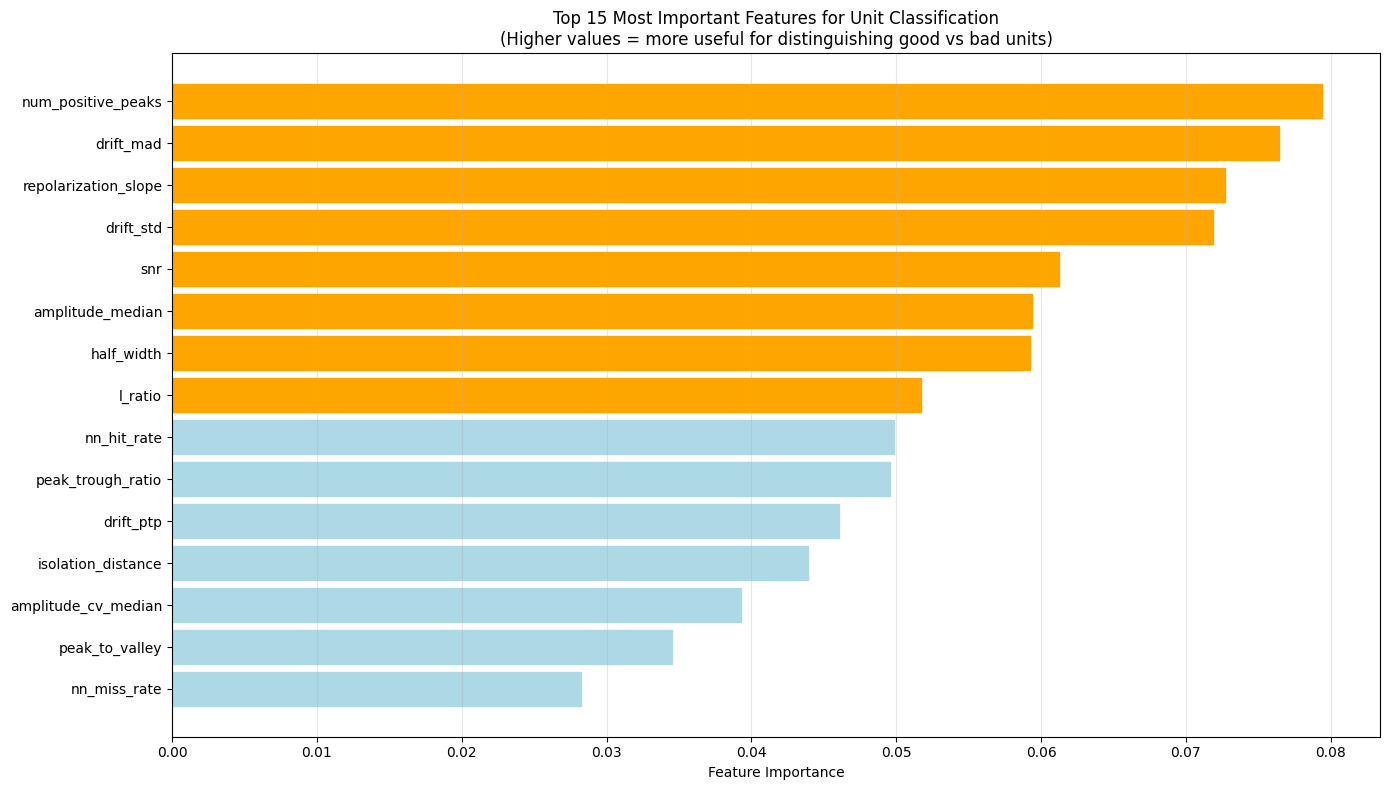


📊 Feature Importance Summary:
   Total features used: 34
   Features with >5% importance: 8
   Top feature contributes: 7.9% of decision making

🏷️  Feature Categories:
   Quality metrics: 11 features
   Template metrics: 5 features
   Other metrics: 18 features


In [10]:
print("📈 Analyzing feature importance...")

# Get feature importances from the best model
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = best_model.feature_names_in_

# Create a DataFrame for easier analysis
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Display top 10 most important features
print(f"🔍 Top 10 Most Important Features:")
print("=" * 50)
for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Plot feature importances
plt.figure(figsize=(14, 8))
top_features = importance_df.head(15)

bars = plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for Unit Classification\n(Higher values = more useful for distinguishing good vs bad units)')
plt.gca().invert_yaxis()

# Color code by importance level
for i, bar in enumerate(bars):
    importance = top_features.iloc[i]['importance']
    if importance > 0.1:
        bar.set_color('darkred')
    elif importance > 0.05:
        bar.set_color('orange')
    else:
        bar.set_color('lightblue')

plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

# Summary statistics
print(f"\n📊 Feature Importance Summary:")
print(f"   Total features used: {len(importance_df)}")
print(f"   Features with >5% importance: {len(importance_df[importance_df['importance'] > 0.05])}")
print(f"   Top feature contributes: {importance_df.iloc[0]['importance']:.1%} of decision making")

# Categorize features by type
quality_features = [f for f in feature_names if any(qm in f.lower() for qm in ['isi', 'rate', 'presence', 'snr', 'amplitude'])]
template_features = [f for f in feature_names if any(tm in f.lower() for tm in ['peak', 'trough', 'width', 'spatial', 'velocity'])]

print(f"\n🏷️  Feature Categories:")
print(f"   Quality metrics: {len(quality_features)} features")
print(f"   Template metrics: {len(template_features)} features")
print(f"   Other metrics: {len(feature_names) - len(quality_features) - len(template_features)} features")

## Next Steps and Model Usage

### Using Your Trained Model

Your custom model is now ready for use! Here are the key files and how to use them:

```python
# Load the trained model
from skops.io import load
model, model_info = load('my_custom_model/best_model.skops', trusted=True)

# Apply to new data (SortingAnalyzer with computed metrics)
predictions = model.predict(new_metrics)
probabilities = model.predict_proba(new_metrics)
```

In [ ]:
# Notebook validation - ensuring proper format